# Reinforcement Learning for Recommender Systems
## From Contextual Bandits to Slate-Q

<table>
<tr>
    <td> <img src="images/youtube.png" style="width: 230px;"/> </td>
    <td> <img src="images/dota2.jpg" style="width: 213px;"/> </td>
    <td> <img src="images/forklifts.jpg" style="width: 169px;"/> </td>
    <td> <img src="images/spotify.jpg" style="width: 254px;"/> </td>
    <td> <img src="images/robots.jpg" style="width: 252px;"/> </td>
</tr>
</table>


### Overview
“Reinforcement Learning for Recommender Systems, From Contextual Bandits to Slate-Q” is a tutorial for industry researchers, domain-experts, and ML-engineers, showcasing ...

1) .. how you can use RLlib to build a recommender system **simulator** for your industry applications and run Bandit algorithms and the Slate-Q algorithm against this simulator.

2) .. how RLlib's offline algorithms pose solutions in case you **don't have a simulator** of your problem environment at hand.

We will further explore how to deploy trained models to production using Ray Serve.

During the live-coding phases, we will using a recommender system simulating environment by google's RecSim and configure and run 2 RLlib algorithms against it. We'll also demonstrate how you may use offline RL as a solution for recommender systems and how to deploy a learned policy into production.

RLlib offers industry-grade scalability, a large list of algos to choose from (offline, model-based, model-free, etc..), support for TensorFlow and PyTorch, and a unified API for a variety of applications. This tutorial includes a brief introduction to provide an overview of concepts (e.g. why RL?) before proceeding to RLlib (recommender system) environments, neural network models, offline RL, student exercises, Q/A, and more. All code will be provided as .py files in a GitHub repo.

### Intended Audience
* Python programmers who are interested in using RL to solve their specific industry decision making problems and who want to get started with RLlib.

### Prerequisites
* Some Python programming experience.
* Some familiarity with machine learning.
* *Helpful, but not required:* Experience in reinforcement learning and Ray.
* *Helpful, but not required:* Experience with TensorFlow or PyTorch.

### Requirements/Dependencies

To get this very notebook up and running on your local machine, you can follow these steps here:

Install conda (https://www.anaconda.com/products/individual)

Then ...

#### Quick `conda` setup instructions (Linux):
```
$ conda create -n rllib_tutorial python=3.9
$ conda activate rllib_tutorial
$ pip install "ray[rllib,serve]" recsim jupyterlab tensorflow torch
```

#### Quick `conda` setup instructions (Mac):
```
$ conda create -n rllib_tutorial python=3.9
$ conda activate rllib_tutorial
$ pip install cmake "ray[rllib,serve]" recsim jupyterlab tensorflow torch
$ pip install grpcio # <- extra install only on apple M1 mac
```

#### Quick `conda` setup instructions (Win10):
```
$ conda create -n rllib_tutorial python=3.9
$ conda activate rllib_tutorial
$ pip install "ray[rllib,serve]" recsim jupyterlab tensorflow torch
$ pip install pywin32 # <- extra install only on Win10.
```

### Opening these tutorial files:
```
$ git clone https://github.com/sven1977/rllib_tutorials
$ cd rllib_tutorials/rl_conference_2022
$ jupyter-lab
```


### Key Takeaways
* What is reinforcement learning and RLlib?
* How do recommender systems work? How do we build our own?
* How do we train RLlib's different algorithms on a recommender system problem?
* (Optional) What's offline RL and how can I use it with RLlib?



### Tutorial Outline

1. Reinforcement learning (RL) in a nutshell.
1. How to formulate any problem as an RL-solvable one?
1. Recommender systems - How they work.
1. Why you should use RLlib.

(10min break)

1. Google RecSim - Build your own recom sys simulator.
1. What are contextual bandits?
1. How to use contextual Bandits with RLlib and start our first training run.
1. What if the environment becomes more difficult? - Intro to Slate-Q.
1. Starting a Slate-Q training run.

(10min break)

1. Intro to Offline RL.
1. What if we don't have an environment? Pretending the output of our previous experiments is historic data with which we can train an offline RL agent.
1. BC and MARWIL: Quick how-to and setup instructions.
1. Off policy evaluation (OPE) as a means to estimate how well an offline-RL trained policy will perform in production.
1. Ray Serve example: How can we deploy a trained policy into our production environment?


### Other Recommended Readings
* [Reinforcement Learning with RLlib in the Unity Game Engine](https://medium.com/distributed-computing-with-ray/reinforcement-learning-with-rllib-in-the-unity-game-engine-1a98080a7c0d)

<img src="images/unity3d_blog_post.png" width=400>

* [Attention Nets and More with RLlib's Trajectory View API](https://medium.com/distributed-computing-with-ray/attention-nets-and-more-with-rllibs-trajectory-view-api-d326339a6e65)
* [Intro to RLlib: Example Environments](https://medium.com/distributed-computing-with-ray/intro-to-rllib-example-environments-3a113f532c70)

# Let's start!

In [1]:
# Let's get started with some basic imports.

import ray  # .. of course
from ray import serve
from ray import tune

from collections import OrderedDict
import gym  # RL environments and action/observation spaces
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
from pprint import pprint
import re
import recsim  # google's RecSim package.
import requests
from scipy.interpolate import make_interp_spline, BSpline
from scipy.stats import linregress, sem
from starlette.requests import Request
import tree  # dm_tree

print("ok")

ok


## Introducing google RecSim

<img src="images/recsim_documentation.png" width=600 style="float:right;">

<a href="https://github.com/google-research/recsim">Google's RecSim package</a> offers a flexible way for you to <a href="https://github.com/google-research/recsim/blob/master/recsim/colab/RecSim_Developing_an_Environment.ipynb">define the different building blocks of a recommender system</a>:


- User model (how do users change their preferences when having been faced with, selected, and consumed certain items?).
- Document model: Features of documents and how do documents get pre-selected/sampled.
- Reward functions.

RLlib comes with 3 off-the-shelf RecSim environments that are ready for training (with RLlib):
* Long Term Satisfaction (<- our first environment)
* Interest Evolution (<- harder env, we'll work with later on)
* Interest Exploration (<- not used today)

In [2]:
# Import a built-in RecSim environment, ready to be trained by RLlib.
from ray.rllib.examples.env.recommender_system_envs_with_recsim import LongTermSatisfactionRecSimEnv

# Create a RecSim instance using the following config parameters (very similar to what we used above in our own recommender system env):
lts_10_1_env = LongTermSatisfactionRecSimEnv({
    "num_candidates": 10,  # Discrete(10) -> int 0-9
    "slate_size": 1,
    "resample_documents": False,  # Set to False for re-using the same candidate doecuments each timestep.
    # Convert MultiDiscrete actions to Discrete (flatten action space).
    # e.g. slate_size=2 and num_candidates=10 -> MultiDiscrete([10, 10]) -> Discrete(100)  # 10x10
    "convert_to_discrete_action_space": True,
})

# What are our spaces?
#print(f"observation space = {lts_10_1_env.observation_space}")
print(f"action space = {lts_10_1_env.action_space}")

action space = Discrete(10)


In [3]:
# Start a new episode and look at initial observation.
obs = lts_10_1_env.reset()
pprint(obs)

OrderedDict([('user', array([], dtype=float32)),
             ('doc',
              {'0': array([0.5488135], dtype=float32),
               '1': array([0.71518934], dtype=float32),
               '2': array([0.60276335], dtype=float32),
               '3': array([0.5448832], dtype=float32),
               '4': array([0.4236548], dtype=float32),
               '5': array([0.6458941], dtype=float32),
               '6': array([0.4375872], dtype=float32),
               '7': array([0.891773], dtype=float32),
               '8': array([0.96366274], dtype=float32),
               '9': array([0.3834415], dtype=float32)}),
             ('response',
              (OrderedDict([('click', 0),
                            ('engagement',
                             array(55.75298, dtype=float32))]),))])


#### Let's play RL agent ourselves and recommend some items (pick some actions):

**Task:** Execute the following cell a couple of times chosing different actions (from 0 - 9) to be sent into the environment's `step()` method. Each time, look at the returned next observation, reward, and `done` flag and write down what you find interesting about the dynamics and observations of this environment.

In [4]:
# Let's send our first action (1-slate back into the env) using the env's `step()` method.
action = 5  # Discrete(10): 0-9 are all valid actions

# This method returns 4 items:
# - next observation (after having applied the action)
# - reward (after having applied the action)
# - `done` flag; if True, the episode is terminated and the environment needs to be `reset()` again.
# - info dict (we'll ignore this)
next_obs, reward, done, _ = lts_10_1_env.step(action)

# Print out the next observation.
# We expect the "doc" and "user" items to be the same as in the previous observation
# b/c we set "resample_documents" to False.
pprint(next_obs)
# Print out rewards and the vlaue of the `done` flag.
print(f"reward = {reward:.2f}; done = {done}")

OrderedDict([('user', array([], dtype=float32)),
             ('doc',
              {'0': array([0.5488135], dtype=float32),
               '1': array([0.71518934], dtype=float32),
               '2': array([0.60276335], dtype=float32),
               '3': array([0.5448832], dtype=float32),
               '4': array([0.4236548], dtype=float32),
               '5': array([0.6458941], dtype=float32),
               '6': array([0.4375872], dtype=float32),
               '7': array([0.891773], dtype=float32),
               '8': array([0.96366274], dtype=float32),
               '9': array([0.3834415], dtype=float32)}),
             ('response',
              ({'click': 1, 'engagement': array(15.293417, dtype=float32)},))])
reward = 15.29; done = False


<br /><br /><br /><br /><br />
<br /><br /><br /><br /><br />
<br /><br /><br /><br /><br />


### What have we learnt from experimenting with the environment?

* User's state (if any) is hidden to agent (not part of observation).
* Episodes seem to last at least n timesteps -> user seems to have some time budget to spend.
* User always seems to click, no matter what we recommend.
* Reward seems to be always identical to the "engagement" value (of the clicked item). These values range somewhere between 0.0 and 20.0+.
* Weak suspicion: If we always recommend the item with the highest feature value, rewards seem to taper off over time - in most of the episodes.
* Weak suspicion: If we always recommend the item with the lowest feature value, rewards seem to increase over time.

In [ ]:
# This cell should help you with your own analysis of the two above suspicions:
# Always chosing the highest/lowest-valued action will lead to a decrease/increase in rewards over the course of an episode.

# Capture slopes of all trendlines over all episodes.
slopes = []
for _ in range(1000):
    # Reset environment to get initial observation:
    obs = lts_10_1_env.reset()

    # Compute actions picking highest and lowest feature values. 
    action_high = np.argmax([value for _, value in obs["doc"].items()])
    action_low = np.argmin([value for _, value in obs["doc"].items()])

    # Play one episode.
    done = False
    rewards = []
    #user_satisfactions = []
    while not done:
        #action = action_high
        action = action_low
        #action = np.random.choice([action_low, action_high])

        obs, reward, done, _ = lts_10_1_env.step(action)
        rewards.append(reward)
        #user_satisfactions.append(lts_10_1_env.env.env.env.env._environment._user_model._user_state.satisfaction)

    # Create linear model of rewards over time.
    reward_linreg = linregress(np.array((range(len(rewards)))), np.array(rewards))
    slopes.append(reward_linreg.slope)
    #user_satisfaction_linreg = linregress(np.array((range(len(user_satisfactions)))), np.array(user_satisfactions))
    #slopes.append(user_satisfaction_linreg.slope)

print(np.mean(slopes))


### What the environment actually does under the hood

Let's take a quick look at a pre-configured RecSim environment: "Long Term Satisfaction".

<img src="images/long_term_satisfaction_env.png" width=1200>

## Measuring random baseline of our environment

In the cells above, we created a new environment instance (`lts_10_1_env`). As we have seen above, in order to start "walking" through a recommender system episode, we need to perform `reset()` and then several `step()` calls (with different actions) until the returned `done` flag is True.

Let's find out how well a randomly acting agent performs in this environment:


In [5]:
# Function that measures and outputs the random baseline reward.
# This is the expected accumulated reward per episode, if we act randomly (recommend random items) at each time step.
def measure_random_performance_for_env(env, episodes=1000, verbose=False):

    # Reset the env.
    obs = env.reset()

    # Number of episodes already done.
    num_episodes = 0
    # Current episode's accumulated reward.
    episode_reward = 0.0
    # Collect all episode rewards here to be able to calculate a random baseline reward.
    episode_rewards = []

    # Enter while loop (to step through the episode).
    while num_episodes < episodes:
        # Produce a random action.
        action = env.action_space.sample()

        # Send the action to the env's `step()` method to receive: obs, reward, done, and info.
        obs, reward, done, _ = env.step(action)
        episode_reward += reward

        # Check, whether the episde is done, if yes, reset and increase episode counter.
        if done:
            if verbose:
                print(f"Episode done - accumulated reward={episode_reward}")
            elif num_episodes % 100 == 0:
                print(f" {num_episodes} ", end="")
            elif num_episodes % 10 == 0:
                print(".", end="")
            num_episodes += 1
            env.reset()
            episode_rewards.append(episode_reward)
            episode_reward = 0.0

    # Print out and return mean episode reward (and standard error of the mean).
    env_mean_random_reward = np.mean(episode_rewards)

    print(f"\n\nMean episode reward when acting randomly: {env_mean_random_reward:.2f}+/-{sem(episode_rewards):.2f}")

    return env_mean_random_reward, sem(episode_rewards)


In [6]:
# Let's create a somewhat tougher version of this with 20 candidates (instead of 10) ad a slate-size of 2.
lts_20_2_env = LongTermSatisfactionRecSimEnv(config={
    "num_candidates": 20,
    "slate_size": 2,  # MultiDiscrete([20, 20]) -> Discrete(400)
    "resample_documents": True,
    # Convert to Discrete action space.
    "convert_to_discrete_action_space": True,
    # Wrap observations for RLlib bandit: Only changes dict keys ("item" instead of "doc").
    "wrap_for_bandits": True,

    # Seed environment for better comparability.
    "seed": 42,
})

lts_20_2_env_mean_random_reward, lts_20_2_env_sem_random_reward = measure_random_performance_for_env(lts_20_2_env, episodes=500)


 0 ......... 100 ......... 200 ......... 300 ......... 400 .........

Mean episode reward when acting randomly: 950.29+/-7.78


# Plugging in RLlib


In [7]:
# Start a new instance of Ray (when running this tutorial locally) or
# connect to an already running one (when running this tutorial through Anyscale).

if not ray.is_initialized():
    ray.init()  # Hear the engine humming? ;)
else:
    print("Ray cluster already running.")
# In case you encounter the following error during our tutorial: `RuntimeError: Maybe you called ray.init twice by accident?`
# Try: `ray.shutdown() + ray.init()` or `ray.init(ignore_reinit_error=True)`

2022-03-23 19:42:14,152	INFO services.py:1490 -- View the Ray dashboard at http://127.0.0.1:8265


## Picking an RLlib algorithm ("Trainer")

https://docs.ray.io/en/master/rllib-algorithms.html#available-algorithms-overview

<img src="images/rllib_algorithms.png">

### Trying a "Contextual n-armed Bandit" on our environment

<img src="images/contextual_bandit.png" width=1000>

In [8]:
# In order to use one of the above algorithms, you may instantiate its associated Trainer class.
# For example, to import a Bandit Trainer w/ Upper Confidence Bound (UCB) exploration, do:

from ray.rllib.agents.bandit import BanditLinUCBTrainer

In [9]:
# Configuration dicts for RLlib Trainers.
# Where are the default configuration dicts stored?

# E.g. Bandit algorithms:
from ray.rllib.agents.bandit.bandit import DEFAULT_CONFIG as BANDIT_DEFAULT_CONFIG
print(f"Bandit's default config is:")
pprint(BANDIT_DEFAULT_CONFIG)

# DQN algorithm:
#from ray.rllib.agents.dqn import DEFAULT_CONFIG as DQN_DEFAULT_CONFIG
#print(f"DQN's default config is:")
#pprint(DQN_DEFAULT_CONFIG)

# Common (all algorithms).
#from ray.rllib.agents.trainer import COMMON_CONFIG
#print(f"RLlib Trainer's default config is:")
#pprint(COMMON_CONFIG)

Bandit's default config is:
{'_disable_action_flattening': False,
 '_disable_execution_plan_api': False,
 '_disable_preprocessor_api': False,
 '_fake_gpus': False,
 '_tf_policy_handles_more_than_one_loss': False,
 'action_space': None,
 'actions_in_input_normalized': False,
 'always_attach_evaluation_results': False,
 'batch_mode': 'truncate_episodes',
 'callbacks': <class 'ray.rllib.agents.callbacks.DefaultCallbacks'>,
 'clip_actions': False,
 'clip_rewards': None,
 'collect_metrics_timeout': -1,
 'compress_observations': False,
 'create_env_on_driver': False,
 'custom_eval_function': None,
 'custom_resources_per_worker': {},
 'disable_env_checking': False,
 'eager_max_retraces': 20,
 'eager_tracing': False,
 'env': None,
 'env_config': {},
 'env_task_fn': None,
 'evaluation_config': {},
 'evaluation_duration': 10,
 'evaluation_duration_unit': 'episodes',
 'evaluation_interval': None,
 'evaluation_num_episodes': -1,
 'evaluation_num_workers': 0,
 'evaluation_parallel_to_training': Fal

# TODO: seed entire bandit, not just the env

In [17]:
bandit_config = {
    "env": LongTermSatisfactionRecSimEnv,
    "env_config": {
        "num_candidates": 20,  # 20x19 = ~400 unique slates (arms)
        "slate_size": 2,
        "resample_documents": True,

        # Bandit-specific flags:
        "convert_to_discrete_action_space": True,
        # Convert "doc" key into "item" key.
        "wrap_for_bandits": True,
        # Use same seed as for the random baseline.
        #"seed": 42,
    },
    "seed": 42,
    
    # The following settings are affecting the reporting only:
    # ---
    # Generate a result dict every single time step.
    "timesteps_per_iteration": 1,
    # Report rewards as smoothed mean over this many episodes.
    "metrics_num_episodes_for_smoothing": 200,
}

# Create the RLlib Trainer using above config.
bandit_trainer = BanditLinUCBTrainer(config=bandit_config)
bandit_trainer

2022-03-23 20:01:01,239	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
2022-03-23 20:01:01,240	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-03-23 20:01:01,251	WARNING util.py:60 -- Install gputil for GPU system monitoring.


BanditLinUCBTrainer

#### Running a single training iteration, by calling the `.train()` method:

One iteration for most algos involves:

1. Sampling from the environment(s)
1. Using the sampled data (observations, actions taken, rewards) to update the policy model (e.g. a neural network), such that it would pick better actions in the future, leading to higher rewards.

Let's try it out:

In [18]:
# Perform single `.train()` call.
result = bandit_trainer.train()
# Erase config dict from result (for better overview).
del result["config"]
# Print out training iteration results.
pprint(result)

{'agent_timesteps_total': 1,
 'custom_metrics': {},
 'date': '2022-03-23_20-01-03',
 'done': False,
 'episode_len_mean': nan,
 'episode_media': {},
 'episode_reward_max': nan,
 'episode_reward_mean': nan,
 'episode_reward_min': nan,
 'episodes_this_iter': 0,
 'episodes_total': 0,
 'experiment_id': '69bc63d20e3f4398a1fb0b485689eb6a',
 'hist_stats': {'episode_lengths': [], 'episode_reward': []},
 'hostname': 'Svens-MacBook-Pro.local',
 'info': {'learner': {'default_policy': {'learner_stats': {'update_latency': 0.0002231597900390625}}},
          'num_agent_steps_sampled': 1,
          'num_agent_steps_trained': 1,
          'num_steps_sampled': 1,
          'num_steps_trained': 1,
          'num_steps_trained_this_iter': 1},
 'iterations_since_restore': 1,
 'node_ip': '127.0.0.1',
 'num_healthy_workers': 0,
 'off_policy_estimator': {},
 'perf': {'cpu_util_percent': 5.425000000000001, 'ram_util_percent': 62.6},
 'pid': 6969,
 'policy_reward_max': {},
 'policy_reward_mean': {},
 'policy_re

 0 .... 500 .... 1000 .... 1500 ....

/var/folders/j4/brrn254576lgnbqqtp5p1z280000gn/T/ipykernel_6969/558393365.py:20: RuntimeWarning: Mean of empty slice
  y = [np.nanmean(rewards[max(i - smoothing_win, 0):i + 1]) for i in range(start_at, len(rewards))]


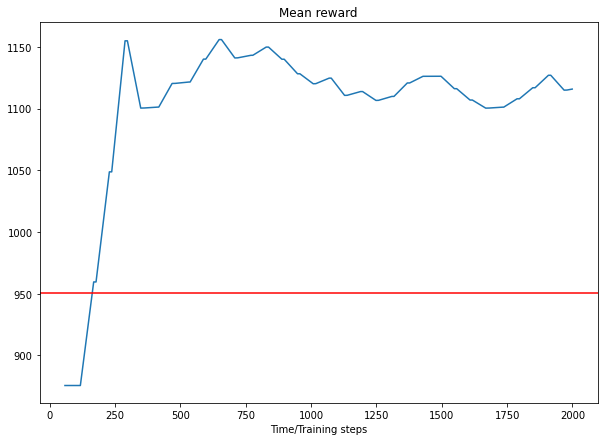

In [19]:
# Train for n more iterations (timesteps) and collect n-arm rewards.
rewards = []
for i in range(2000):
    # Run a single timestep in the environment and update
    # the model immediately on the received reward.
    result = bandit_trainer.train()
    # Extract reward from results.
    #rewards.extend(result["hist_stats"]["episode_reward"]
    rewards.append(result["episode_reward_mean"])
    if i % 500 == 0:
        print(f" {i} ", end="")
    elif i % 100 == 0:
        print(".", end="")

# Plot per-timestep (episode) rewards.
plt.figure(figsize=(10,7))
start_at = 0
smoothing_win = 50
x = list(range(start_at, len(rewards)))
y = [np.nanmean(rewards[max(i - smoothing_win, 0):i + 1]) for i in range(start_at, len(rewards))]
plt.plot(x, y)
plt.title("Mean reward")
plt.xlabel("Time/Training steps")

# Add mean random baseline reward (red line).
plt.axhline(y=lts_20_2_env_mean_random_reward, color="r", linestyle="-")

plt.show()

### What does our trained Bandit actually recommend?

The first method of the RLlib Trainer API we used above was `train()`.
We'll now use another method of the Trainer, `compute_single_action(input_dict={})`.
It takes a input_dict keyword arg, into which you may pass a single (unbatched!) observation to receive an action for:

In [15]:
# Let's see what items our bandit recommends now that it has been trained and achieves good (>> random) rewards.
obs = lts_20_2_env.reset()
# Pass the single (unbatched) observation into the `compute_single_action` method of our Trainer.
# This is one way to perform inference on a learned policy.
action = bandit_trainer.compute_single_action(input_dict={"obs": obs})

# Print out observation, action, and the picked document's feature value.
print(f"observation = {obs}\naction = {action}")
print(f"feature-value of picked doc = {obs['item'][action]}")

observation = OrderedDict([('item', array([[0.276838  ],
       [0.8762376 ],
       [0.379856  ],
       [0.6738267 ],
       [0.7856481 ],
       [0.18969162],
       [0.6529893 ],
       [0.44552284],
       [0.34763512],
       [0.8018209 ],
       [0.40165967],
       [0.32068956],
       [0.989645  ],
       [0.82297796],
       [0.9904996 ],
       [0.87910205],
       [0.70007366],
       [0.47070515],
       [0.97827214],
       [0.56680703]], dtype=float32))])
action = 14
feature-value of picked doc = [0.9904996]


### Ok, Bandits want Chocolate! :)

### Recap: Advantages and Disatvantages of Bandits:
#### Advantages:
* Very fast
* Very sample-efficient
* Easy to understand learning process

#### Disadvantages
* Need immediate reward (not good at long-horizon credit assignment)
* Models user -> If > 1 user, must train separate bandit per user
* Not able to handle components of MultiDiscrete action space separately (works only on flattened Discrete action space)

## Introducing another, harder RecSim example environment: Interest Evolution

So far, we have trained a UCB Bandit against the LongTermSatisfaction environment. A seemingly quite simple problem to solve, however, we have seen
that a Bandit cannot - for design reasons - learn the best long-term strategy, which is to not only pick the most click-baitey items always, but
to also present the user with healthy/kale items from time to time to allow the user's internal satisfactisfaction value to increase.

Let's now move to a more complex RecSim environmeent: The InterestEvolution env.

<img src="images/interest_evolution_env.png" width=1200>

### Switching to Slate-Q

RLlib offers another algorithm - Slate-Q - designed for k-slate, long time horizon, and dynamic user recommendation problems. Let's take a quick look:

<img src="images/slateq.png" width=1000>

# TODO: Create single instance  of IEV env and measuer its random performance first and use that variable in the !optional hack! cell below

In [20]:
# Import a Trainable (one of RLlib's built-in algorithms):
# We use the SlateQ algorithm here b/c it is specialized in solving slate recommendation problems
# and works well with RLlib's RecSim environment adapter.

from ray.rllib.agents.slateq import SlateQTrainer
from ray.rllib.examples.env.recommender_system_envs_with_recsim import InterestEvolutionRecSimEnv


slateq_config = {
    "env": InterestEvolutionRecSimEnv,
    "env_config": {
        "num_candidates": 20,
        "slate_size": 2,
        "resample_documents": True,
        "wrap_for_bandits": False,  # SlateQ != Bandit
        "convert_to_discrete_action_space": False,  # SlateQ handles MultiDiscrete action spaces (slate recommendations).
    },
    "exploration_config": {
        "warmup_timesteps": 10000,
        "epsilon_timesteps": 25000,
    },
    "replay_buffer_config": {
        "capacity": 100000,
    },
    "learning_starts": 10000,
    "target_network_update_freq": 3200,

    # Report rewards as smoothed mean over this many episodes.
    "metrics_num_episodes_for_smoothing": 200,
}

# Instantiate the Trainer object using the exact same config as in our last (harder-to-solve env) Bandit experiment above.
slateq_trainer = SlateQTrainer(config=slateq_config)
slateq_trainer

2022-03-23 20:09:15,868	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
2022-03-23 20:09:15,869	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.


Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use fn_output_signature instead
/Users/sven/opt/anaconda3/envs/rllib_tutorial/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("default_policy/gradients/default_policy/GatherV2_5_grad/Reshape_1:0", shape=(?,), dtype=int64), values=Tensor("default_policy/gradients/default_policy/GatherV2_5_grad/Reshape:0", shape=(?,), dtype=float32), dense_shape=Tensor("default_policy/gradients/default_policy/GatherV2_5_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
2022-03-23 20:09:32,250	INFO trainable.py:145 -- Trainable.setup took 16.407 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-03-23 20:09:32,252	WARNING util.py:60 -- Install gputil for GPU system monitoring.


SlateQTrainer

In [21]:
# Run a single training iteration.
results = slateq_trainer.train()

# Delete the config from the results for clarity.
# Only the stats will remain, then.
del results["config"]
# Pretty print the stats.
pprint(results)

{'agent_timesteps_total': 10000,
 'custom_metrics': {},
 'date': '2022-03-23_20-15-49',
 'done': False,
 'episode_len_mean': 83.3,
 'episode_media': {},
 'episode_reward_max': 196.29245049971104,
 'episode_reward_mean': 153.6553772549946,
 'episode_reward_min': 130.84703979568383,
 'episodes_this_iter': 120,
 'episodes_total': 120,
 'experiment_id': 'b87486b9dbd944ea91ea8deb002130a7',
 'hist_stats': {'episode_lengths': [97,
                                    80,
                                    89,
                                    74,
                                    77,
                                    75,
                                    76,
                                    80,
                                    87,
                                    81,
                                    83,
                                    79,
                                    92,
                                    106,
                                    81,
           

Now that we have confirmed we have setup the Trainer correctly, let's call `train()` on it several times:

In [ ]:
# Run `train()` n times. Repeatedly call `train()` now to see rewards increase.
for _ in range(100):
    results = slateq_trainer.train()
    print(f"Iteration={slateq_trainer.iteration}: R(\"return\")={results['episode_reward_mean']}")

#### !OPTIONAL HACK!

Feel free to play around with the following code in order to learn how RLlib - under the hood - calculates actions from the environment's observations using the SlateQ Policy and its NN models inside our Trainer object):

In [23]:
# To get the policy inside the Trainer, use `Trainer.get_policy([policy ID]="default_policy")`:
policy = slateq_trainer.get_policy()
print(f"Our Policy right now is: {policy}")

# To get to the model inside any policy, do:
model = policy.model
#print(f"Our Policy's model is: {model}")

# Print out the policy's action and observation spaces.
print(f"Our Policy's observation space is: {policy.observation_space}\n")
print(f"Our Policy's action space is: {policy.action_space}\n")

# Produce a random obervation (B=1; batch of size 1).
obs = ie.observation_space.sample()

# tf-specific code: Use tf1.Session().
sess = policy.get_session()

# Get the action logits (as torch tensor).
with sess.graph.as_default():
    q_values_per_candidate = model.q_value_head([
        np.expand_dims(obs["user"], 0),
        np.expand_dims(np.concatenate([value for value in obs["doc"].values()]), 0),
    ])
print(f"q_values_per_candidate={sess.run(q_values_per_candidate)}")

Our Policy right now is: SlateQTFPolicy
Our Policy's observation space is: Dict(user:Box([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.], [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], (20,), float32), doc:Dict(0:Box([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.], [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], (20,), float32), 1:Box([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.], [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], (20,), float32), 2:Box([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.], [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], (20,), float32), 3:Box([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.], [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], (20,), float32), 4:Box([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.

NameError: name 'env' is not defined

#### !END: OPTIONAL HACK!

In order to release all resources from a Trainer, you can use a Trainer's `stop()` method.
You should definitley run this cell as it frees resources that we'll need later in this tutorial, when we'll do parallel hyperparameter sweeps.

In [ ]:
# In order to release resources that a Trainer uses, you can call its `stop()` method:
slateq_trainer.stop()

### Recap: Advantages and Disadvantages of SlateQ:
#### Advantages:
* Decomposes MultiDiscrete action space (better understanding of items inside a k-slate)
* Handles long-horizon credit assignment better than bandits (Q-learning)
* Handles > 1 user problems
* Sample efficient (due to replay buffer + off-policy DQN-style learning)

#### Disadvantages
* Uses larger (deep) model(s): One Q-value NN head per candidate
* Slower and heavier feel to it
* Requires careful hyperparameter-tuning, e.g. exploration timesteps.

------------------
## 10 min break :)

... (while Slate-Q is running .. and hopefully learning).

------------------

## Introduction to Offline RL

<img src="images/offline_rl.png" width=800>

In [24]:
# The previous tune.run (the one we did before the break) produced "historic data" output.
# We will use this output in the following as input to a newly initialized, untrained offline RL algorithm.

# Let's take a look at the generated file(s) first:
output_dir = "offline_rl/"
#print(output_dir)

# Here is what the best log directory contains:
print("\n\nThe logdir contains the following files:")
all_output_files = os.listdir(os.path.dirname(output_dir + "/"))
pprint(all_output_files)

json_output_file = os.path.join(output_dir, [f for f in all_output_files if re.match("^.*worker.*\.json$", f)][0])
print("\n\nThe JSON file with all sampled trajectories is:")
print(json_output_file)



The logdir contains the following files:
['README.py',
 'output-2022-03-14_13-16-05_worker-2_239.json',
 '.ipynb_checkpoints']


The JSON file with all sampled trajectories is:
offline_rl/output-2022-03-14_13-16-05_worker-2_239.json


### Using an (offline) input file with an offline RL algorithm.

We will now pretend that we don't have a simulator for our problem (same recommender system problem as above) available, however, let's assume we possess a lot of pre-recorded, historic data from some legacy (non-RL) system.

Assuming that this legacy system wrote some data into a JSON file (we'll simply use the same JSON file that our SlateQ algo produced above), how can we use this historic data to do RL either way?

In [25]:
# Let's take a look at the output file first:
dataframe = pandas.read_json(json_output_file, lines=True)  # don't forget lines=True -> Each line in the json is one "rollout" of 4 timesteps.
dataframe.head()


,type,obs,new_obs,actions,prev_actions,rewards,prev_rewards,dones,infos,eps_id,unroll_id,agent_index,t,vf_preds,action_dist_inputs,action_prob,action_logp,advantages,value_targets
0,SampleBatch,"[[0.947974801063537, 0.7422540783882141, -0.30...","[[0.947974801063537, 0.7422540783882141, -0.30...","[[18, 13], [16, 4], [19, 15], [19, 18], [19, 1...","[[4, 11], [18, 13], [16, 4], [19, 15], [19, 18...","[0.0, 4.0, 0.0, 4.0, 4.0, 0.0, 4.0, 0.0, 4.0, ...","[4.0, 0.0, 4.0, 0.0, 4.0, 4.0, 0.0, 4.0, 0.0, ...","[False, False, False, False, False, False, Fal...",[{'env': '<recsim.simulator.environment.Single...,"[1118026545, 1118026545, 1118026545, 111802654...","[1613, 1613, 1613, 1613, 1613, 1613, 1613, 161...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[29.020187377929688, 23.39920425415039, 13.822...","[[1.67626404762268, 0.6096312403678891, -1.030...","[0.0018913851818060001, 0.007846021093428001, ...","[-6.270445823669434, -4.847748756408691, -6.56...","[70.58807373046875, 77.21520233154297, 83.7674...","[99.60826110839844, 100.6144027709961, 97.5903..."


In [26]:
# Let's configure a new RLlib Trainer, one that's capable of reading the JSON input described
# above and able to learn from this input.

# For simplicity, we'll start with a behavioral cloning (BC) trainer:
from ray.rllib.agents.marwil.bc import BCTrainer

interest_evolution_env = InterestEvolutionRecSimEnv({
    "num_candidates": 20,
    "slate_size": 2,
    "wrap_for_bandits": False,  # SlateQ != Bandit
    "convert_to_discrete_action_space": False,
})



offline_rl_config = {
    # Specify your offline RL algo's historic (JSON) inputs:
    "input": [json_output_file],
    # Note: For non-offline RL algos, this is set to "sampler" by default.
    #"input": "sampler",

    # Since we don't have an environment and the obs/action-spaces are not defined in the JSON file,
    # we need to provide these here manually.
    "env": None,  # default
    "observation_space": interest_evolution_env.observation_space,
    "action_space": interest_evolution_env.action_space,

    # Perform "off-policy estimation" (OPE) on train batches and report results.
    "input_evaluation": ["is", "wis"],
}

# Create a behavior cloning (BC) Trainer.
bc_trainer = BCTrainer(config=offline_rl_config)
bc_trainer


2022-03-23 20:31:18,668	WARNING util.py:60 -- Install gputil for GPU system monitoring.


BCTrainer

In [27]:
# Let's train our new behavioral cloning Trainer for some iterations:
for _ in range(5):
    results = bc_trainer.train()
    print(f"{results['info']['num_agent_steps_trained']} steps trained; reward = {results['episode_reward_mean']}")


2000 steps trained; reward = nan
4000 steps trained; reward = nan
6000 steps trained; reward = nan
8000 steps trained; reward = nan
10000 steps trained; reward = nan


In [ ]:
# Oh no! What happened?
# We don't have an environment! No way to measure rewards per episode.

# A quick fix would be:

# A) We cheat! Let's use our environment from above to run some separate evaluation workers on while we train:

offline_rl_config_w_evaluation = offline_rl_config.copy()
offline_rl_config_w_evaluation.update({
    # Add a (parallel) evaluation trackm, using 1 additional ray worker and running for
    # 100 episodes (`evaluation_duration[_unit]?`) each training iteration (`evaluation_interval`).
    "evaluation_interval": 1,
    "evaluation_parallel_to_training": True,
    "evaluation_num_workers": 1,
    "evaluation_duration": 100,
    "evaluation_duration_unit": "episodes",
    # Must change the input setting to point to an environment.
    "evaluation_config": {
        "env": InterestEvolutionRecSimEnv,
        "env_config": slateq_config["env_config"],
        "input": "sampler",
    },
})

In [ ]:
bc_trainer_w_evaluation = BCTrainer(config=offline_rl_config_w_evaluation)
print(bc_trainer_w_evaluation.evaluation_workers)
bc_trainer_w_evaluation.evaluate()
# Let's train our new behavioral cloning Trainer for some iterations:
for _ in range(5):
    results_w_evaluation = bc_trainer_w_evaluation.train()
    print(results_w_evaluation["episode_reward_mean"])

In [ ]:
# B) If you really, really don't have an environment, use "off-policy estimation" (OPE):

# `results` still holds the last output of our non-evaluation BCTrainer.
# Extract off-policy estimator (OPE) results for the different methods:
# is=importance sampling
# wis=weighted importance sampling
pprint(results["off_policy_estimator"]["is"])
pprint(results["off_policy_estimator"]["wis"])


### Saving and restoring a trained Trainer.
Currently, `bc_trainer` is in an already trained state.
It holds optimized weights in its Q-value/Policy's models that allow it to act
already somewhat smart in our environment when given an observation.

However, if we closed this notebook right now, all the effort would have been for nothing.
Let's therefore save the state of our trainer to disk for later!

In [ ]:
# We use the `Trainer.save()` method to create a checkpoint.
checkpoint_file = bc_trainer.save()
print(f"Trainer (at iteration {bc_trainer.iteration} was saved in '{checkpoint_file}'!")

# Here is what a checkpoint directory contains:
print("The checkpoint directory contains the following files:")
os.listdir(os.path.dirname(checkpoint_file))

### Restoring and evaluating a Trainer
In the following cell, we'll learn how to restore a saved Trainer from a checkpoint file.

We'll also evaluate a completely new Trainer (should act more or less randomly) vs an already trained one (the one we just restored from the created checkpoint file).

In [ ]:
# Pretend, we wanted to pick up training from a previous run:
new_trainer = BCTrainer(config=offline_rl_config)
# Evaluate the new trainer (this should yield random results).
results = new_trainer.evaluate()
print(f"Evaluating new trainer: R={results['evaluation']['episode_reward_mean']}")

# Restoring the trained state into the `new_trainer` object.
print(f"Before restoring: Trainer is at iteration={new_trainer.iteration}")
new_trainer.restore(checkpoint_file)
print(f"After restoring: Trainer is at iteration={new_trainer.iteration}")

# Evaluate again (this should yield results we saw after having trained our saved agent).
results = new_trainer.evaluate()
print(f"Evaluating restored trainer: R={results['evaluation']['episode_reward_mean']}")

In [ ]:
serve.start()

@serve.deployment(route_prefix="/interest-evolution")
class ServeModel:
    def __init__(self, checkpoint_path) -> None:
        self.trainer = BCTrainer(
            config=offline_rl_config,
        )
        self.trainer.restore(checkpoint_path)

    async def __call__(self, request: Request):
        json_input = await request.json()
        obs = json_input["observation"]
        # Translate obs back to np.arrays.
        np_obs = OrderedDict(tree.map_structure(lambda s: np.array(s) if isinstance(s, list) else s, obs))
        action = self.trainer.compute_single_action(np_obs)
        return {"action": action}


ServeModel.deploy(checkpoint_file)


In [ ]:
# Request 5 actions of an episode from served policy.

obs = interest_evolution_env.reset()

for _ in range(5):
    # Convert numpy arrays to lists (needed for transfer).
    obs = tree.map_structure(lambda s: s.tolist() if isinstance(s, np.ndarray) else s, obs)

    print(f"-> Sending observation {obs}")
    resp = requests.get(
        "http://localhost:8000/interest-evolution", json={"observation": obs}
    )
    response_json = resp.json()
    print(f"<- Received response {response_json}")
    obs, _, _, _ = interest_evolution_env.step(np.array(response_json["action"]))


## Time for Q&A

...

## Thank you for listening and participating!

### Here are a couple of links that you may find useful.

- The <a href="https://github.com/sven1977/rllib_tutorials/tree/main/rl_conference_2022">github repo of this tutorial</a>.
- <a href="https://docs.ray.io/en/latest/rllib/index.html">RLlib's documentation main page</a>.
- <a href="http://discuss.ray.io">Our discourse forum</a> to ask questions on Ray and its libraries.
- Our <a href="https://forms.gle/9TSdDYUgxYs8SA9e8">Slack channel</a> for interacting with other Ray RLlib users.
- The <a href="https://github.com/ray-project/ray/blob/master/rllib/examples/">RLlib examples scripts folder</a> with tons of examples on how to do different stuff with RLlib.
- A <a href="https://medium.com/distributed-computing-with-ray/reinforcement-learning-with-rllib-in-the-unity-game-engine-1a98080a7c0d">blog post on training with RLlib inside a Unity3D environment</a>.


In [ ]:
# Ignore everything below this line!
# vv

In [ ]:
from ray.rllib.examples.env.recommender_system_envs_with_recsim import InterestEvolutionRecSimEnv

# Update our env: Making things harder.
# Leave the env_config the same as for the
# LongTermEvolution env: 20 candidates, slate-size=2
bandit_config.update({
    "env": InterestEvolutionRecSimEnv,
    "env_config": dict(bandit_config["env_config"], **{
        "num_candidates": 100,
        "slate_size": 3,  # 100*99*98 ~ 1M
        "seed": 0,
    }),
})

# Re-computing our random baseline.
interest_evolution_env_for_bandits = InterestEvolutionRecSimEnv(config=bandit_config["env_config"])
iev_100_3_env_mean_random_reward, _ = measure_random_performance_for_env(interest_evolution_env_for_bandits, episodes=200)

# Create the RLlib Trainer using above config.
bandit_trainer = BanditLinUCBTrainer(config=bandit_config)

# Train for n iterations (timesteps) and collect n-arm rewards.
rewards = []
for i in range(3000):
    result = bandit_trainer.train()
    rewards.append(result["episode_reward_mean"])
    if i % 500 == 0:
        print(f" {i} ", end="")
    elif i % 100 == 0:
        print(".", end="")

# Plot per-timestep (episode) rewards.
plt.figure(figsize=(10,7))
start_at = 100
smoothing_win = 500
x = list(range(start_at, len(rewards)))
y = [np.nanmean(rewards[max(i - smoothing_win, 0):i]) for i in range(start_at, len(rewards))]
plt.plot(x, y)
plt.title("Mean reward")
plt.xlabel("Time/Training steps")

# Add mean random baseline reward (red line).
plt.axhline(y=iev_100_3_env_mean_random_reward, color="r", linestyle="-")

plt.show()

### Here is one possible outcome for 1M timesteps:

<img src="images/iev_100_3_bandit_performance.png">